Goal: find similarities within groups of users in order to cluster based on preferred reading genres.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [57]:
# Import average user ratings by genre
avg_ratings = pd.read_csv('user-avg-rating-2-genres.csv')
avg_ratings.head()

,user_id,avg_fantasy,avg_mystery
0,5,4.500000,4.200000
1,10,4.000000,4.000000
2,11,3.500000,4.000000
3,14,3.500000,4.000000
4,23,3.666667,3.066667


In [58]:
# Create delimited subset of data to get user ratings who prefer either
# fantasy or mystery

def preferred_genre_data(avg_ratings, score_limit_1, score_limit_2):
    
    preferred_data = avg_ratings[((avg_ratings['avg_fantasy'] < score_limit_1 - 0.2) & (avg_ratings['avg_mystery'] > score_limit_2)) |
                                 ((avg_ratings['avg_mystery'] < score_limit_1) & (avg_ratings['avg_fantasy'] > score_limit_2))]
    
    preferred_data = pd.concat([preferred_data[:300], avg_ratings[:2]])
    
    preferred_data = pd.DataFrame(preferred_data.to_records())
    
    return preferred_data

preferred_data = preferred_genre_data(avg_ratings, 3.2, 2.5)
preferred_data = preferred_data.drop('index',axis=1)

print( "Number of records: ", len(preferred_data))

preferred_data.head()

Number of records:  302


,user_id,avg_fantasy,avg_mystery
0,23,3.666667,3.066667
1,27,4.000000,2.000000
2,35,2.888889,3.285714
3,36,3.600000,2.500000
4,44,3.500000,2.750000


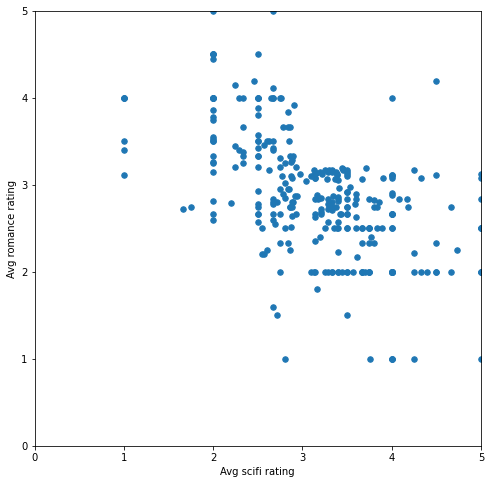

In [59]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

draw_scatterplot(preferred_data['avg_fantasy'],'Avg scifi rating',
                 preferred_data['avg_mystery'], 'Avg romance rating')

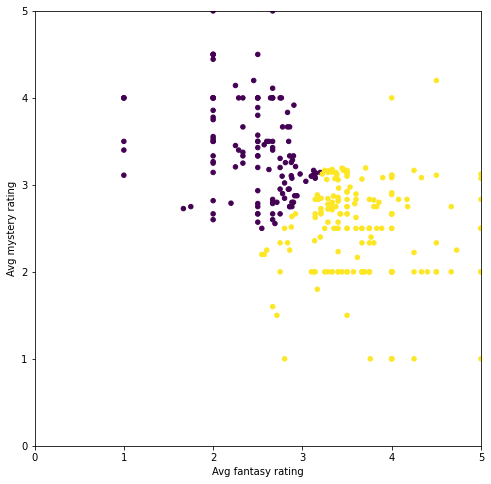

In [63]:
X = preferred_data[['avg_fantasy','avg_mystery']].values

from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(preferred_data, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg fantasy rating')
    ax.set_ylabel('Avg mystery rating')
    
    clustered = pd.concat([preferred_data.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_fantasy'], clustered['avg_mystery'], c=clustered['group'], s=20, cmap=cmap)
    
draw_clusters(preferred_data, predictions)

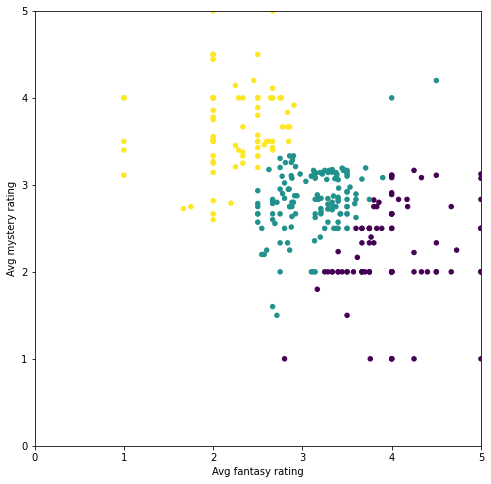

In [66]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)

# Plot
draw_clusters(preferred_data, predictions_2)

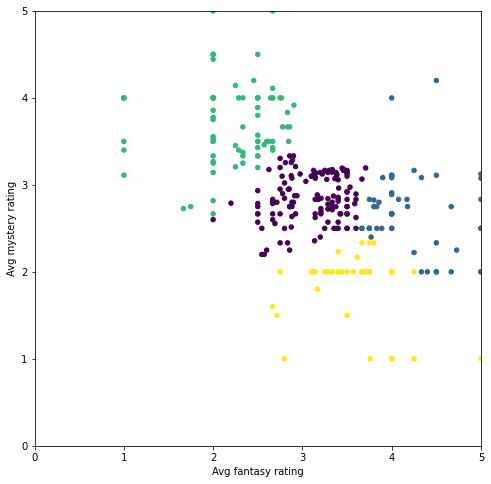

In [68]:
# Create an instance of KMeans to find four clusters
kmeans_3 = KMeans(n_clusters=4)

# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

# Plot
draw_clusters(preferred_data, predictions_3)

